## Analyzing Search Engine Results Pages on a Large Scale

If you do SEO, a big part of your job is tracking your rankings on SERP's, as well as your competitors'.  
I'm going to be sharing a way to get SERP data and have it in a DataFrame (table / csv / excel sheet) for analysis, on a large scale, and in an automated way.  

I will be using the programming language Python, so there will be some coding involved. If you don't know any programming, you can simply ignore the code snippets below, as you don't need to understand them to follow along. 

So how exactly are we going to get the data, and what are we going to do with it? 

### Importing the data
Google's Custom Search Engine is a service that allows you to create your own customized search engine, where you can specify certain sites to crawl, and set your own relevancy rules. You can also programmatically pull the data throug their API, which is what we are going to do. If you don't specify any specific rules then your custom search engine will basically be searching the whole web. In addition, you have the ability to specify many parameters for your search queries; the location of the user, the language of the site, image search, and many more. 

Here are the steps to setup your account to import data (skip if you don't want to run the code yourself). 

1. [Create a custom search engine](https://cse.google.com/cse/). At first you might be asked to enter a site to search. Enter any domain, then go to the control panel and remove it. Make sure you enable "Search the entire web" and image search. You will also need to get your search engine ID, which you can find on the control panel page.
2. [Enable the custom search API](https://console.cloud.google.com/apis/library/customsearch.googleapis.com). You will need to create a project for this first.
3. [Create credentials for this project](https://console.developers.google.com/apis/api/customsearch.googleapis.com/credentials) so you can get your key.
4. [Enable billing for your project](https://console.cloud.google.com/billing/projects) If you want to run more than 100 queries per day. The first 100 queries are free, then for each 1,000 queries you pay $5.  


### Handling the data
We will be using three Python packages for our work: 
* [advertools](https://github.com/eliasdabbas/advertools): To connect to the Google CSE API and receive SERPs in a table format. 
* [pandas](https://pandas.pydata.org/): For data manipulation, reshaping, merging, sorting, etc. 
* [matplotlib](https://matplotlib.org/): For data visualization. 


To give you a quick idea, here is a sample from the SERP response that we will be working with:

In [1]:
import pandas as pd
serp_flights = pd.read_csv('serp_flights.csv')
serp_flights.head()

searchTerms  rank  \
0  flights to hong kong     1   
1  flights to hong kong     2   
2  flights to hong kong     3   
3  flights to hong kong     4   
4  flights to hong kong     5   

                                               title  \
0  Cheap Flights to Hong Kong (HKG) from $401 - K...   
1  $458 Flights to Hong Kong, China (HKG) - TripA...   
2  Cheap Flights to Hong Kong SAR, Asia $307.69 i...   
3  Cheap Flights to Hong Kong International from ...   
4  Flights to Hong Kong (HKG) | Hong Kong Flight ...   

                                             snippet  \
0  Find flights to Hong Kong on XiamenAir, Hong K...   
1  Cheap Flights to Hong Kong: Enter your dates o...   
2  Expedia Add-On Advantage: Book a flight & unlo...   
3  The Magnificent City of Hong Kong. Check for c...   
4  Find & book great deals on Hong Kong (HKG) Fli...   

                 displayLink  \
0              www.kayak.com   
1        www.tripadvisor.com   
2            www.expedia.com   
3         www.skyscanner.com   
4  flights.cathaypacific.com   

                                                link  \
0  https://www.kayak.com/flight-routes/United-Sta...   
1  https://www.tripadvisor.com/Flights-g294217-Ho...   
2  https://www.expedia.com/Cheap-Flights-To-Hong-...   
3  https://www.skyscanner.com/flights-to/hkg/chea...   
4  https://flights.cathaypacific.com/en-us/flight...   

                          queryTime  totalResults       cacheId  \
0  2018-11-21 03:03:21.596540+00:00      12700000  W42baDpas_gJ   
1  2018-11-21 03:03:21.596540+00:00      12700000  5jsjhmxgxvkJ   
2  2018-11-21 03:03:21.596540+00:00      12700000  iEmRbX0P8CAJ   
3  2018-11-21 03:03:21.596540+00:00      12700000  EI78TI4Q1qYJ   
4  2018-11-21 03:03:21.596540+00:00      12700000  q6kszaD7mggJ   

                                        formattedUrl          ...           \
0  https://www.kayak.com/flight-routes/United.../...          ...            
1  https://www.tripadvisor.com/Flights-g294217-Ho...          ...            
2  https://www.expedia.com/Cheap-Flights-To-Hong-...          ...            
3  https://www.skyscanner.com/flights-to/hkg/chea...          ...            
4  https://flights.cathaypacific.com/en-us/flight...          ...            

  count startIndex inputEncoding outputEncoding safe  \
0    10          1          utf8           utf8  off   
1    10          1          utf8           utf8  off   
2    10          1          utf8           utf8  off   
3    10          1          utf8           utf8  off   
4    10          1          utf8           utf8  off   

                                  cx  gl  searchTime formattedSearchTime  \
0  012859022920491477448:pubdbfjmmec  us    0.428278                0.43   
1  012859022920491477448:pubdbfjmmec  us    0.428278                0.43   
2  012859022920491477448:pubdbfjmmec  us    0.428278                0.43   
3  012859022920491477448:pubdbfjmmec  us    0.428278                0.43   
4  012859022920491477448:pubdbfjmmec  us    0.428278                0.43   

  formattedTotalResults  
0            12,700,000  
1            12,700,000  
2            12,700,000  
3            12,700,000  
4            12,700,000  

[5 rows x 26 columns]

A few notes on the different columns available:  

"queryTime" is the time that the query was run (when I made the request). This is different from "searchTime" which is the amount of time it took Google to run the query (usually less than one second). 
Most of the main columns will always be there, but if you pass different parameters you will have more or less columns. For example, you would have columns describing the images, in case you specify the type of search to be "image". 

### The dataset
We are going to take a look at the airlines tickets industry, and here are the details: 
- Destinations: I got the top 100 destinations from Wikipedia and used them as the basis for the queries. 
- Keywords: each destination was prepended with two variations, so we will be looking at "trips to destination" and "tickets to destination"
- Countries: Each variation of those was requested for one of two English-speaking countries; The United States, and The United Kingdom
- SERPs: Naturally, each result contains ten links, together with their metadata. 

As a result we have 100 destinations x 2 variations x 2 countries x 10 results = 4,000 rows of data.  

We begin by importing the packages that we will use, and defining our Google CSE ID and key:

In [2]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import advertools as adv
import pandas as pd
pd.set_option('display.max_columns', None)
cx = 'YOUR_GOOGLE_CUSTOM_SEARCH_ENGINE_ID'
key = 'YOUR_GOOGLE_DEVELOPER_KEY'

Now we can import the Wikipedia table, and here are the top destinations with some additional data: 

In [3]:
# top_dest = pd.read_html('https://en.wikipedia.org/wiki/List_of_cities_by_international_visitors', 
# header=0)[0]
# top_dest.to_csv('top_destinations.csv', index=False)
top_dest = pd.read_csv('top_destinations.csv')
top_dest.head().style.format({'Arrivals 2016Euromonitor': '{:,}'})

Create the keywords by concatenating the two variations mentioned above: 

In [4]:
cities = top_dest['City'].tolist()
queries = ['flights to ' + c.lower() for c in cities] + ['tickets to ' + c.lower() for c in cities]
queries[:3] + queries[-3:] + ['etc...']

['flights to hong kong',
 'flights to bangkok',
 'flights to london',
 'tickets to qingdao',
 'tickets to philadelphia',
 'tickets to lagos',
 'etc...']

With the main parameters defined, we can now send the requests to Google as follows: 

In [5]:
# serp_flights = adv.serp_goog(cx=cx, key=key, q=queries, gl=['us', 'uk'])  # imports data

In [6]:
serp_flights = pd.read_csv('serp_flights.csv',parse_dates=['queryTime'])
serp_us = serp_flights[serp_flights['gl'] == 'us'].copy() # create a subset for US
serp_uk = serp_flights[serp_flights['gl'] == 'uk'].copy() # create a subset for UK

Let's now take a quick look at the top domains. 

In [7]:
print('Domain Summary - Overall')
(serp_flights
 .pivot_table('rank', 'displayLink', 
              aggfunc=['count', 'mean'])
 .sort_values([('count', 'rank'), ('mean', 'rank')], 
              ascending=[False, True])
 .assign(coverage=lambda df: df[('count', 'rank')] / len(serp_flights)*10)
 .head(10).style.format({("coverage", ''): "{:.1%}", 
                         ('mean', 'rank'): '{:.2f}'}))

Domain Summary - Overall


As you see, since we are mainly interested in the ranking of domains we have it summarized by three main metrics: 
1. Count: the number of times that the domain appeared in the searches that we made
2. Mean: the mean (average) rank of each of the domains
3. Coverage: this is simply the count divided by the number of queries. 

The above pivot table is for all the results, and to get a quick overview. I think it's more meaningful to split the data into two different pivot tables, one for each of the countries: 

In [8]:
print('Domain Summary - US')
(serp_flights[serp_flights['gl']=='us']
 .pivot_table('rank', 'displayLink', 
              aggfunc=['count', 'mean'])
 .sort_values([('count', 'rank'), ('mean', 'rank')], 
              ascending=[False, True])
 .assign(coverage=lambda df: df[('count', 'rank')] / len(serp_flights)*10 * 2)
 .head(10).style.format({("coverage", ''): "{:.1%}", 
                         ('mean', 'rank'): '{:.2f}'}))


Domain Summary - US


For coverage, I divided by 400 in the first table, but for the countries I'm dividing by 200, because we are interested in queries for that country. An interesting point here, is that kayak.com has lower coverage than tripadvisor.com, but it has a higher mean rank. In top positions, the difference between position two and three is quite high in terms of value. Depending on your case, you might value one or the other (metric). 

In [9]:
print('Domain Summary - UK')
(serp_flights[serp_flights['gl']=='uk']
 .pivot_table('rank', 'displayLink', 
              aggfunc=['count', 'mean'])
 .sort_values([('count', 'rank'), ('mean', 'rank')], 
              ascending=[False, True])
 .assign(coverage=lambda df: df[('count', 'rank')] / len(serp_flights)*10*2)
 .head(10).style.format({("coverage", ''): "{:.1%}", 
                         ('mean', 'rank'): '{:.2f}'}))

Domain Summary - UK


Having a coverage of 108% means that skyskanner.net has appeared on all searches, and in some cases they appeared more than once in the same SERP.  
Note that their mean rank is 1.45, much higher than the second domain.  
No joking with SkySkanner!  

Now that we have an idea about the number of times they appeared and the average ranks they have, it might also be good to visualize the data, so we can see how it is distributed.  
We first get the top 10 domains for each country, and define two new DataFrames (tables) containing only the filtered data and then visualize: 

In [10]:
top10_domains = serp_flights.displayLink.value_counts()[:10].index
top10_df = serp_flights[serp_flights['displayLink'].isin(top10_domains)]

top10_domains_us = serp_us.displayLink.value_counts()[:10].index
top10_df_us = serp_flights[serp_flights['displayLink'].isin(top10_domains_us)]

top10_domains_uk = serp_uk.displayLink.value_counts()[:10].index
top10_df_uk = serp_flights[serp_flights['displayLink'].isin(top10_domains_uk)]

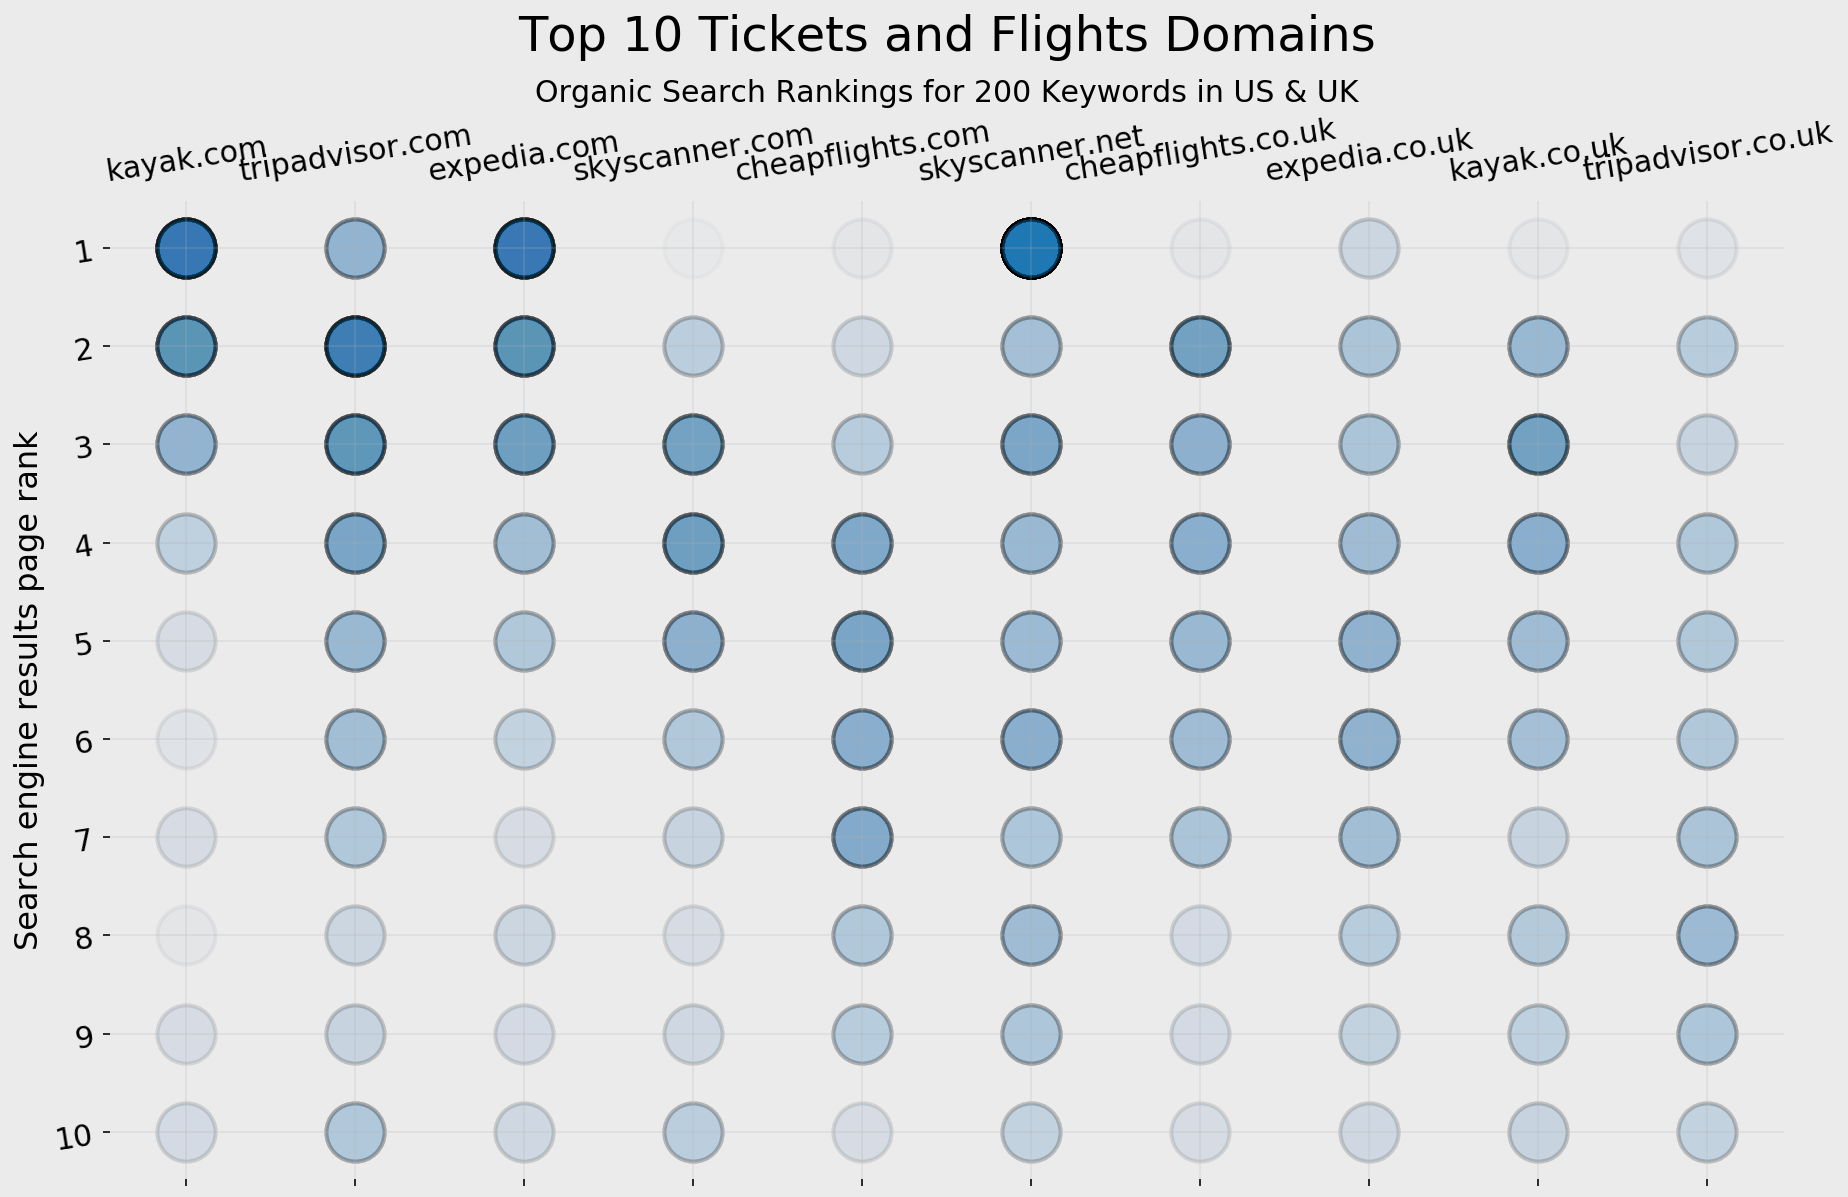

In [11]:
fig, ax = plt.subplots(facecolor='#ebebeb')
fig.set_size_inches(15, 9)
ax.set_frame_on(False)
ax.scatter(top10_df['displayLink'].str.replace('www.', ''), 
           top10_df['rank'], s=850, alpha=0.02, edgecolor='k', lw=2)
ax.grid(alpha=0.25)
ax.invert_yaxis()
ax.yaxis.set_ticks(range(1, 11))
ax.tick_params(labelsize=15, rotation=9, labeltop=True,
               labelbottom=False)
ax.set_ylabel('Search engine results page rank', fontsize=16)
ax.set_title('Top 10 Tickets and Flights Domains', pad=75, fontsize=24)
ax.text(4.5, -0.5, 'Organic Search Rankings for 200 Keywords in US & UK', 
        ha='center', fontsize=15)
fig.savefig(ax.get_title() + '.png', 
            facecolor='#eeeeee', dpi=150, bbox_inches='tight')
plt.show()

For each appearance on an SERP we plot a very light circle in the position where that domain appeared (from one to ten). The more frequently a domain appears, the darker the circle.  
For example, kayak.com, expedia.com, and skyskanner.net have solid blue circles on position one, as well as lighter ones on different positions.  

A minor issue in this analysis so far is that it treats all keywords equally. The number of tourists in the top one hundred list varies between two and twentysix million, so they are clearly not equal. Also, for your specific case, you might have your own set of "top 100" based on the website you are working on. But since we are exploring the industry and trying to understand the positions of the different players, I don't think it's a bad assumption. Just keep this in mind when doing a similar analysis for a specific case. 

As above, this was for the overall data, and below is the same visualization split by country: 

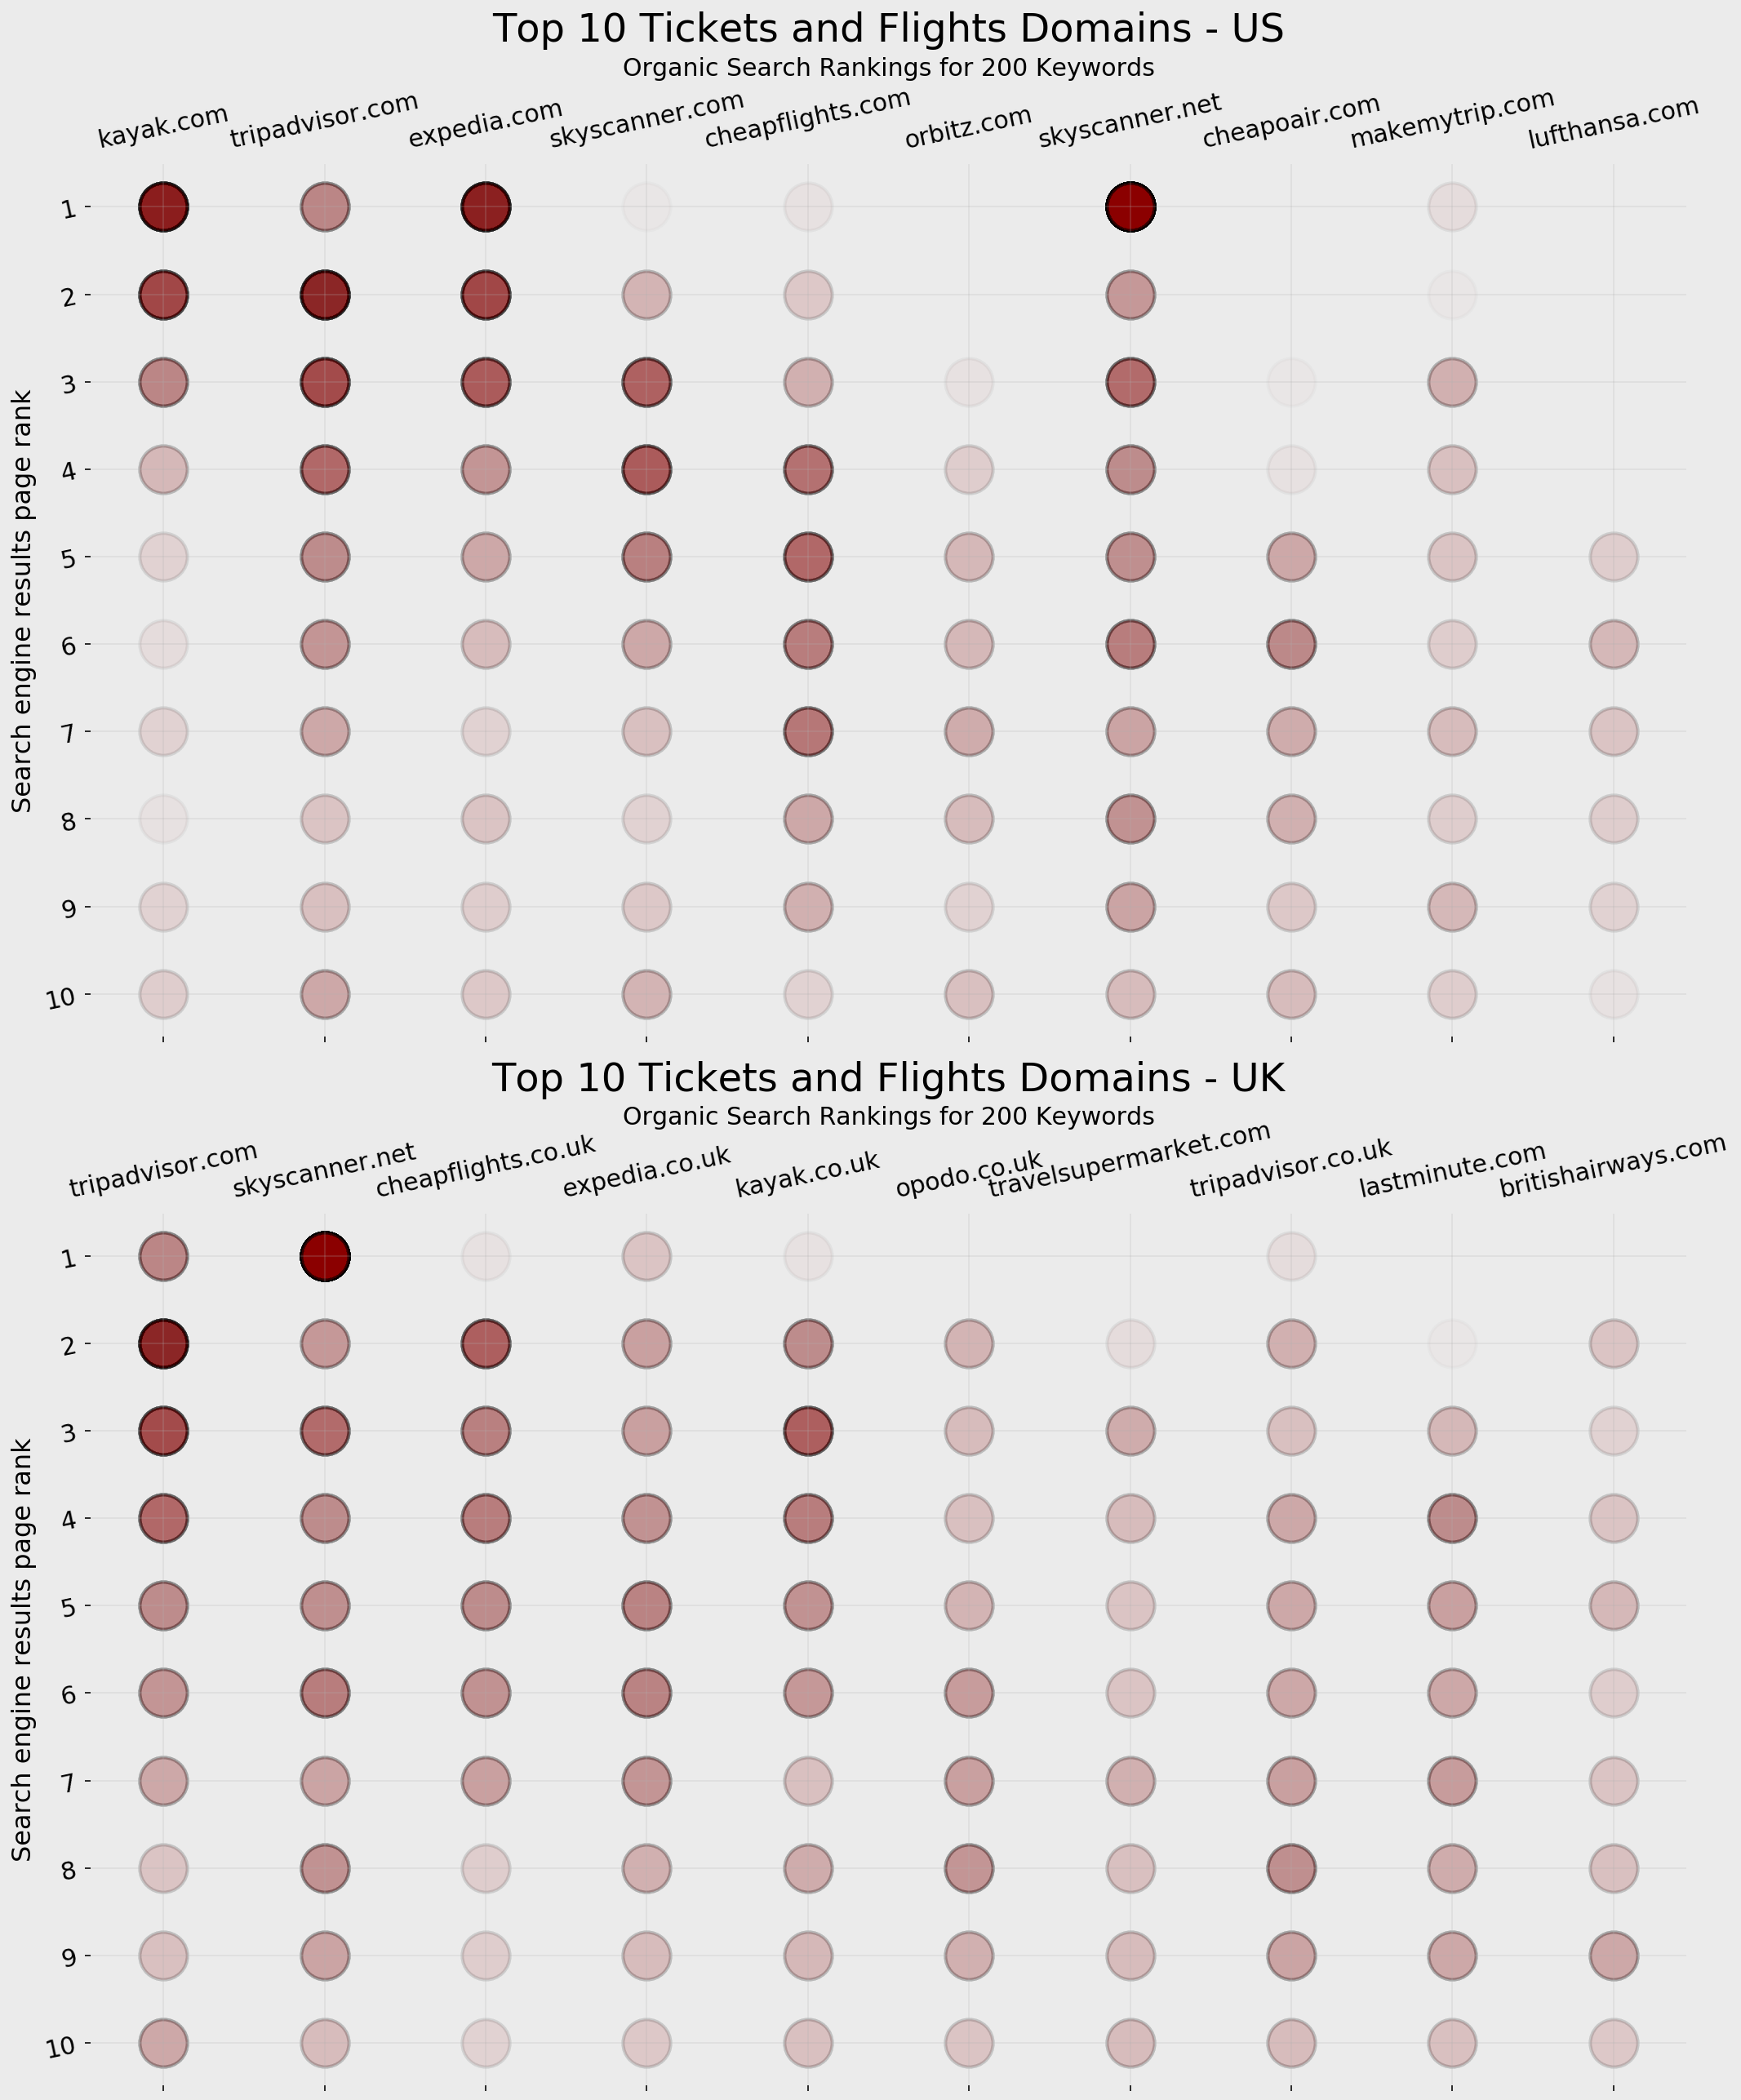

In [12]:
top10_dfs = [top10_df_us, top10_df_uk]
colors = ['darkred', 'olive']
suffixes = [' - US', ' - UK']
fig, ax = plt.subplots(2, 1, facecolor='#ebebeb')
fig.set_size_inches(15, 18)
for i in range(2):
    ax[i].set_frame_on(False)
    ax[i].scatter(top10_dfs[i]['displayLink'].str.replace('www.', ''), 
                  top10_dfs[i]['rank'], s=850, alpha=0.02, 
                  edgecolor='k', lw=2, color='darkred')
    ax[i].grid(alpha=0.25)
    ax[i].invert_yaxis()
    ax[i].yaxis.set_ticks(range(1, 11))
    ax[i].tick_params(labelsize=15, rotation=12, labeltop=True,
                   labelbottom=False)
    ax[i].set_ylabel('Search engine results page rank', fontsize=16)
    ax[i].set_title('Top 10 Tickets and Flights Domains' + suffixes[i], 
                    pad=75, fontsize=24)
    ax[i].text(4.5, -0.5, 'Organic Search Rankings for 200 Keywords', 
            ha='center', fontsize=15)
plt.tight_layout()
fig.savefig(ax[i].get_title() + '.png', 
            facecolor='#eeeeee', dpi=150, bbox_inches='tight')
    

plt.show()

### Content quantity

Another important metric you might be interested in, is how many pages each domain has for the different cities.  
Assuming the content is real, and with a minimum level of quality, the more content you have, the more likely you are to appear on SERPs, especially for keyword variations and the different combinations users can think of.  
One of the parameters of the request allowed by Google is specifying the site you want to search in, and you have the option to include or exclude that site.  
So if we search for "tickets to hong kong" and specify `siteSearch=www.tripadvisor.com` with `siteSearchFilter=i` (for "include") we will get the search results restricted to that site only.  
An important column that comes together with every response is "totalResults", which shows how many pages Google has for that query.  
Since that query was restricted to a certain domain, and is for a specific keyword, we can figure out how many pages that domain has, that are eligible to appear for that keyword.  
I ran the queries for the top five destinations, and for the two countries. 

In [13]:
# pagesperdomain_us = adv.serp_goog(cx=cx, key=key, q=queries[:5], 
#                                   siteSearch=top10_domains_us.tolist(), 
#                                   siteSearchFilter='i', num=1)
# pagesperdomain_uk = adv.serp_goog(cx=cx, key=key, q=queries[:5], 
#                                   siteSearch=top10_domains_uk.tolist() , 
#                                   siteSearchFilter='i', num=1)
# pagesperdomain_us.to_csv('pagesperdomain_us.csv', index=False)
# pagesperdomain_uk.to_csv('pagesperdomain_uk.csv', index=False)

In [14]:
pagesperdomain_us = pd.read_csv('pagesperdomain_us.csv')
pagesperdomain_uk = pd.read_csv('pagesperdomain_uk.csv')

Here are the first ten results from the US for "flights to hong kong" and below a visualization for each of the keywords and the countries:

In [15]:
(pagesperdomain_us
 [['searchTerms', 'displayLink', 'totalResults']]
 .head(10)
 .style.format({'totalResults': '{:,}'}))

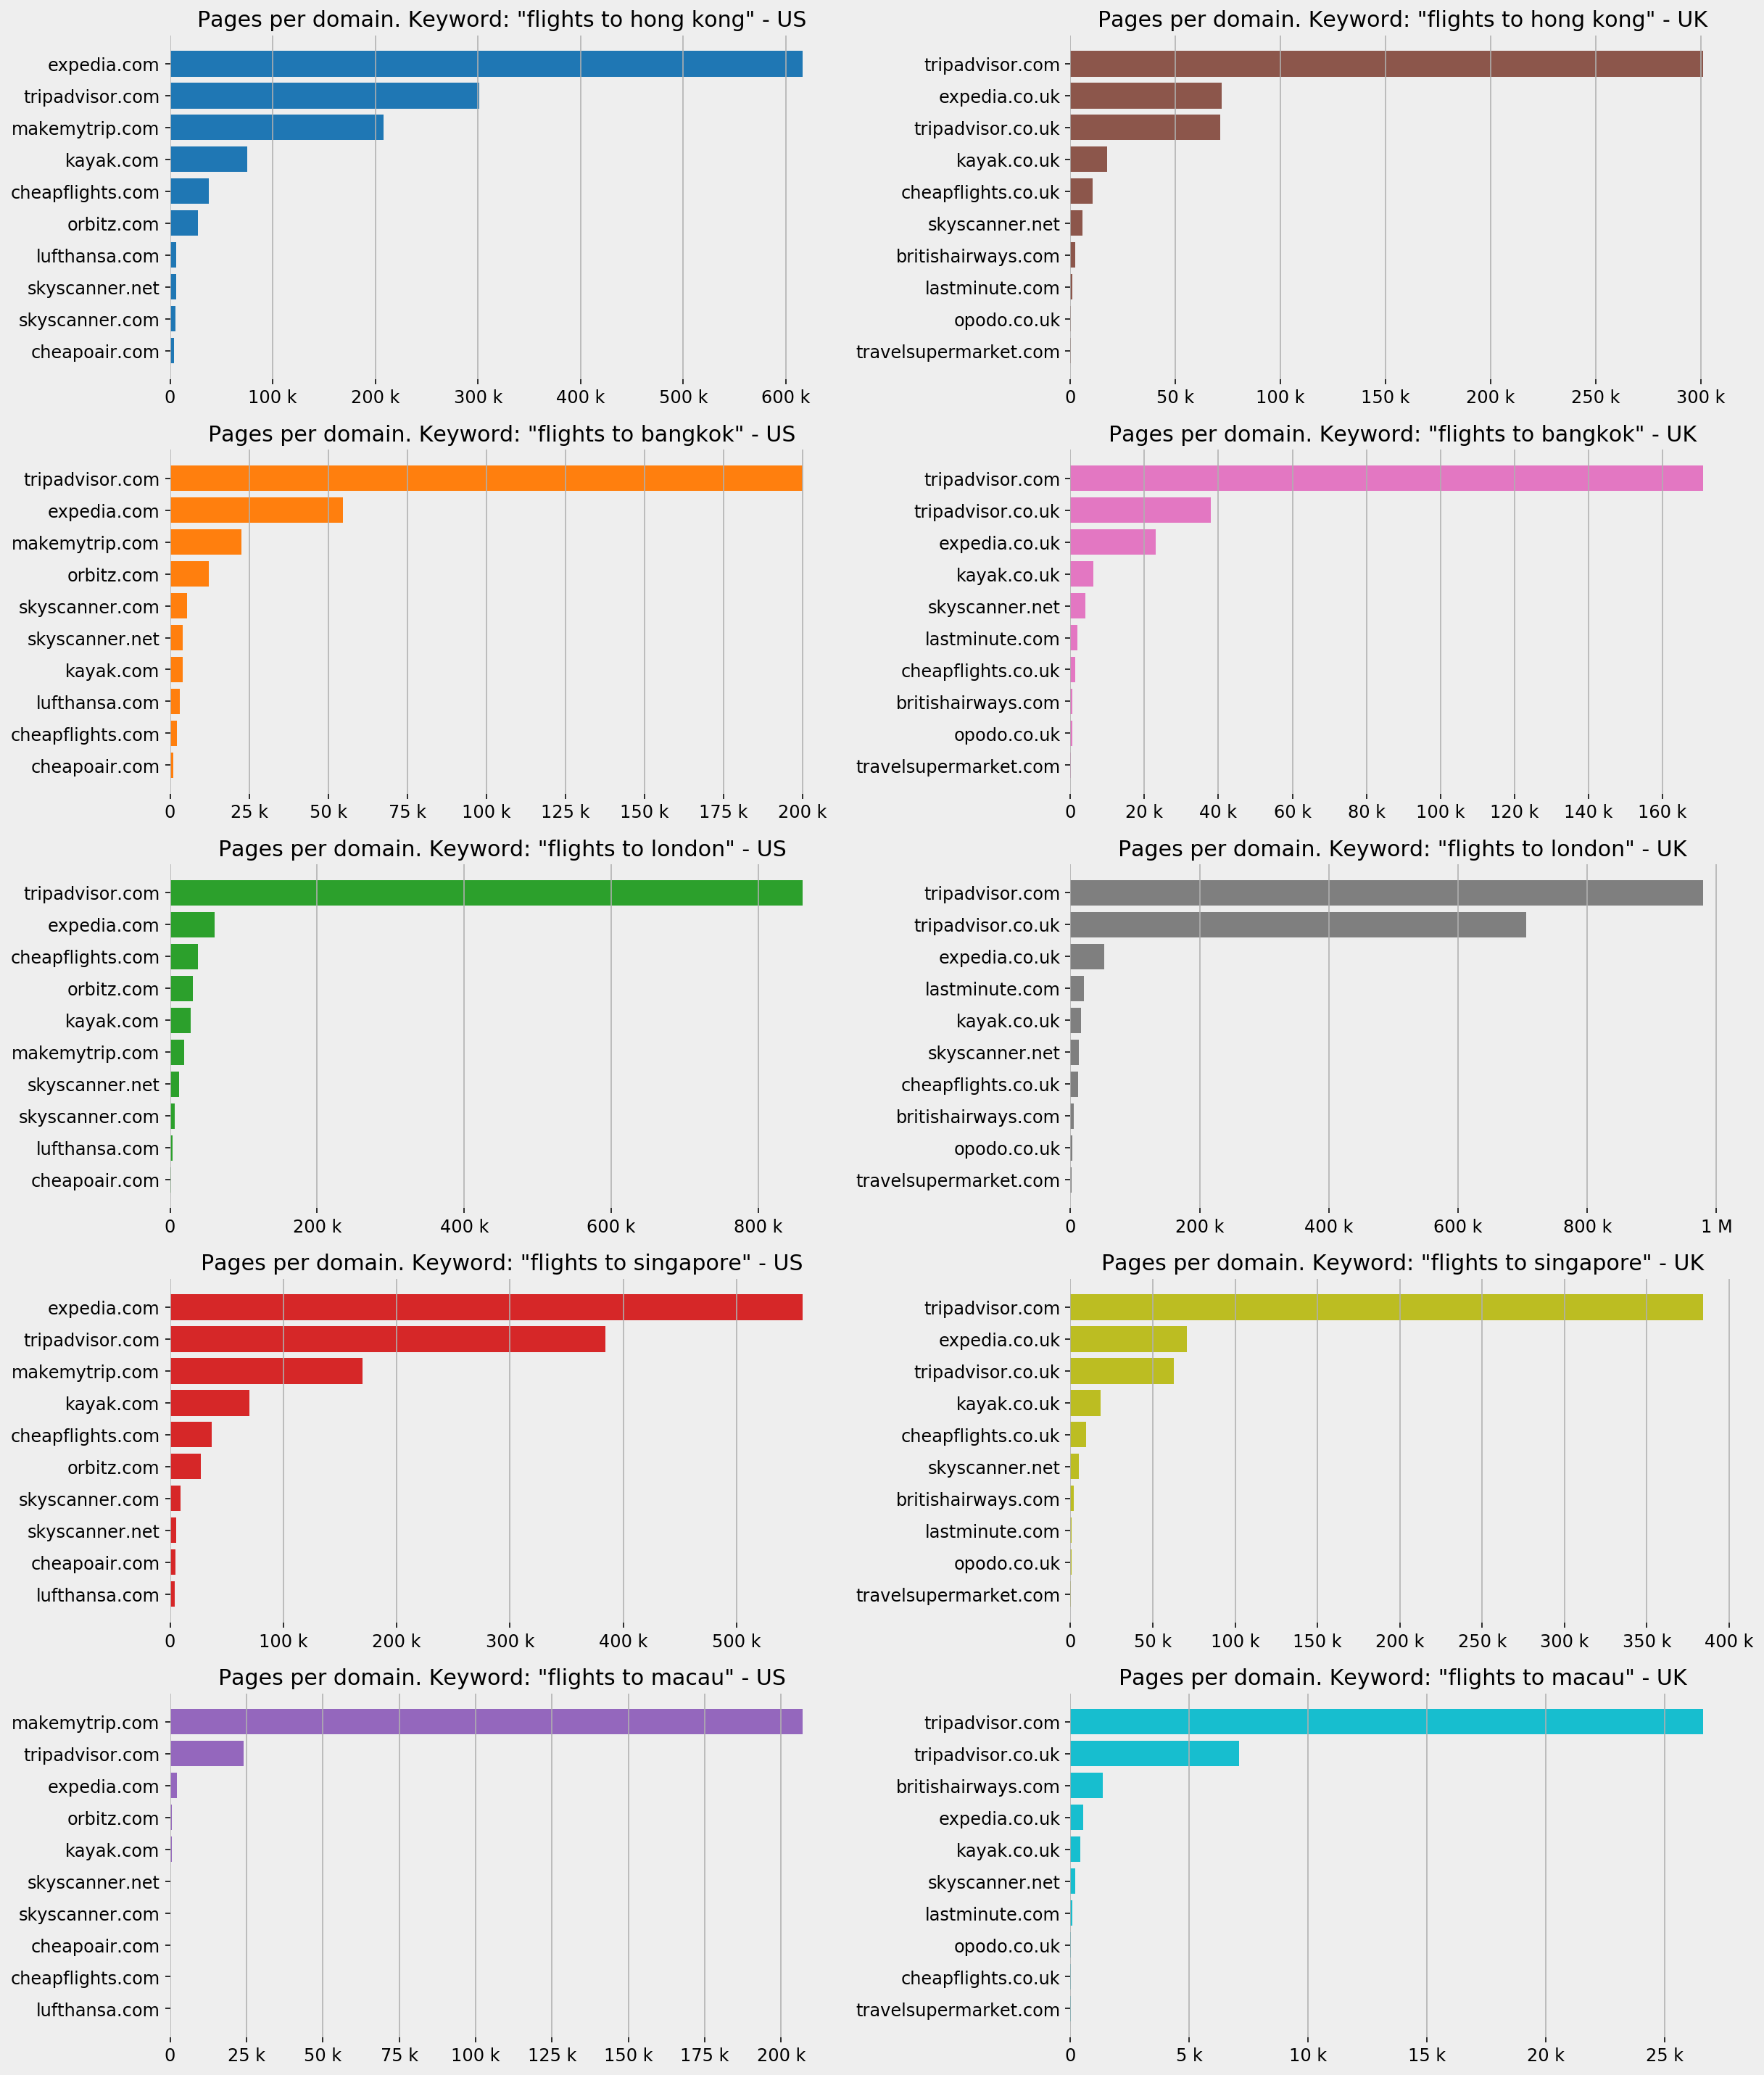

In [16]:
from matplotlib.cm import tab10
from matplotlib.ticker import EngFormatter
fig, ax = plt.subplots(5, 2, facecolor='#eeeeee')
fig.set_size_inches(17, 20)
countries = [' - US', ' - UK']
pages_df = [pagesperdomain_us, pagesperdomain_uk]
for i in range(5):
    for j in range(2):
        ax[i, j].set_frame_on(False)
        ax[i, j].barh((pages_df[j][pages_df[j]['searchTerms']== queries[i]]
                       .sort_values('totalResults')['displayLink']
                       .str.replace('www.', '')),
                      (pages_df[j][pages_df[j]['searchTerms']== queries[i]]
                       .sort_values('totalResults')['totalResults']),
                      color=tab10.colors[i+5*j])
        ax[i, j].grid(axis='x')
        ax[i, j].set_title('Pages per domain. Keyword: "' +  queries[i] + '"' + countries[j],
                           fontsize=15)
        ax[i, j].tick_params(labelsize=12)
        ax[i, j].xaxis.set_major_formatter(EngFormatter())
plt.tight_layout()
fig.savefig('Pages per domain' + '.png', 
            facecolor='#eeeeee', dpi=150, bbox_inches='tight')
plt.show()


As you can see, the difference can be drammatic in some cases, and it doesn't always correlate with top positions. Feel free to analyze further, or try other keywords if you are interested. 

### Analyzing titles
There are many ways to analyze titles (and snippets), but in this case, one particular thing caught my attention, and I think it's very important in this industry.  
Many sites have the price of the tickets in the title of the page, which is visible in SERPs and is one of the most important factors encouraging / discouraging people to click. For example: 

In [17]:
serp_flights[serp_flights['searchTerms'] == 'flights to paris'][['searchTerms', 'title']].head(10)

searchTerms                                              title
120  flights to paris     Cheap Flights to Paris (PAR) from $269 - KAYAK
121  flights to paris  $309 Flights to Paris, France (PAR) - TripAdvisor
122  flights to paris  Cheap Flights to Paris, Ile-de-France (CDG Air...
123  flights to paris  Cheap Flights to Paris, France - Search Deals ...
124  flights to paris                 Cheap Flights to Paris | CheapOair
125  flights to paris     $309.98 + Flights to Paris (PAR) on Orbitz.com
126  flights to paris  Cheap Flights to Paris from $259 in 2019 | Sky...
127  flights to paris  Flight to Paris - Cheap flights to France | Ai...
128  flights to paris          Cheap Flights to Paris from $15 | JETCOST
129  flights to paris  Cheap Paris Return Flights, 2018 PAR Airfare @...

Let's now extract the prices and currencies, so we can do further analysis. 

In [18]:
serp_flights['price'] = (serp_flights['title']
                         .str.extract('[$£](\d+,?\d+\.?\d+)')[0]
                         .str.replace(',', '').astype(float))
serp_flights['currency'] = serp_flights['title'].str.extract('([$£])')
serp_flights[['searchTerms', 'title', 'price', 'currency', 'displayLink']].head(15)

searchTerms                                              title  \
0   flights to hong kong  Cheap Flights to Hong Kong (HKG) from $401 - K...   
1   flights to hong kong  $458 Flights to Hong Kong, China (HKG) - TripA...   
2   flights to hong kong  Cheap Flights to Hong Kong SAR, Asia $307.69 i...   
3   flights to hong kong  Cheap Flights to Hong Kong International from ...   
4   flights to hong kong  Flights to Hong Kong (HKG) | Hong Kong Flight ...   
5   flights to hong kong  Deal Alert: Nonstop Flights to Hong Kong From ...   
6   flights to hong kong  Cheap Flights to Hong Kong - Search Deals on A...   
7   flights to hong kong       Flights to Hong Kong SAR (HKG) on Orbitz.com   
8   flights to hong kong  Fly Hong Kong Airlines | Flights To & From Hon...   
9   flights to hong kong  Passenger Arrivals, Flights - Hong Kong Intern...   
10  flights to hong kong  Cheap Flights to Hong Kong International from ...   
11  flights to hong kong  Cheap Flights to Hong Kong from £359 - Cheapfl...   
12  flights to hong kong   Flights to Hong Kong SAR (HKG Airport) | Expedia   
13  flights to hong kong  Cheap Flights to Hong Kong (HKG) from £361 - K...   
14  flights to hong kong  Cheap flights to Hong Kong from £115 - Book tr...   

     price currency                displayLink  
0   401.00        $              www.kayak.com  
1   458.00        $        www.tripadvisor.com  
2   307.69        $            www.expedia.com  
3   385.00        $         www.skyscanner.com  
4      NaN      NaN  flights.cathaypacific.com  
5   511.00        $           thepointsguy.com  
6      NaN      NaN       www.cheapflights.com  
7      NaN      NaN             www.orbitz.com  
8      NaN      NaN   www.hongkongairlines.com  
9      NaN      NaN    www.hongkongairport.com  
10  354.00        £         www.skyscanner.net  
11  359.00        £     www.cheapflights.co.uk  
12     NaN      NaN          www.expedia.co.uk  
13  361.00        £            www.kayak.co.uk  
14  115.00        £            www.opodo.co.uk

Now we have two new columns "price" and "currency". 
In some cases there is no price in the title "NaN" for (not a number), and there are dollar and pound signs. 
Some sites also have the prices in other currencies, but they are very small in number, and it doesn't make sense to compare those especially when there are big differences in their values, so we will only be dealing with dollars and pounds.  
For the top five queries, we can plot the different prices (where available), and get a quick overview of how the prices compare.  
Here is a quick price comparison engine for you :)

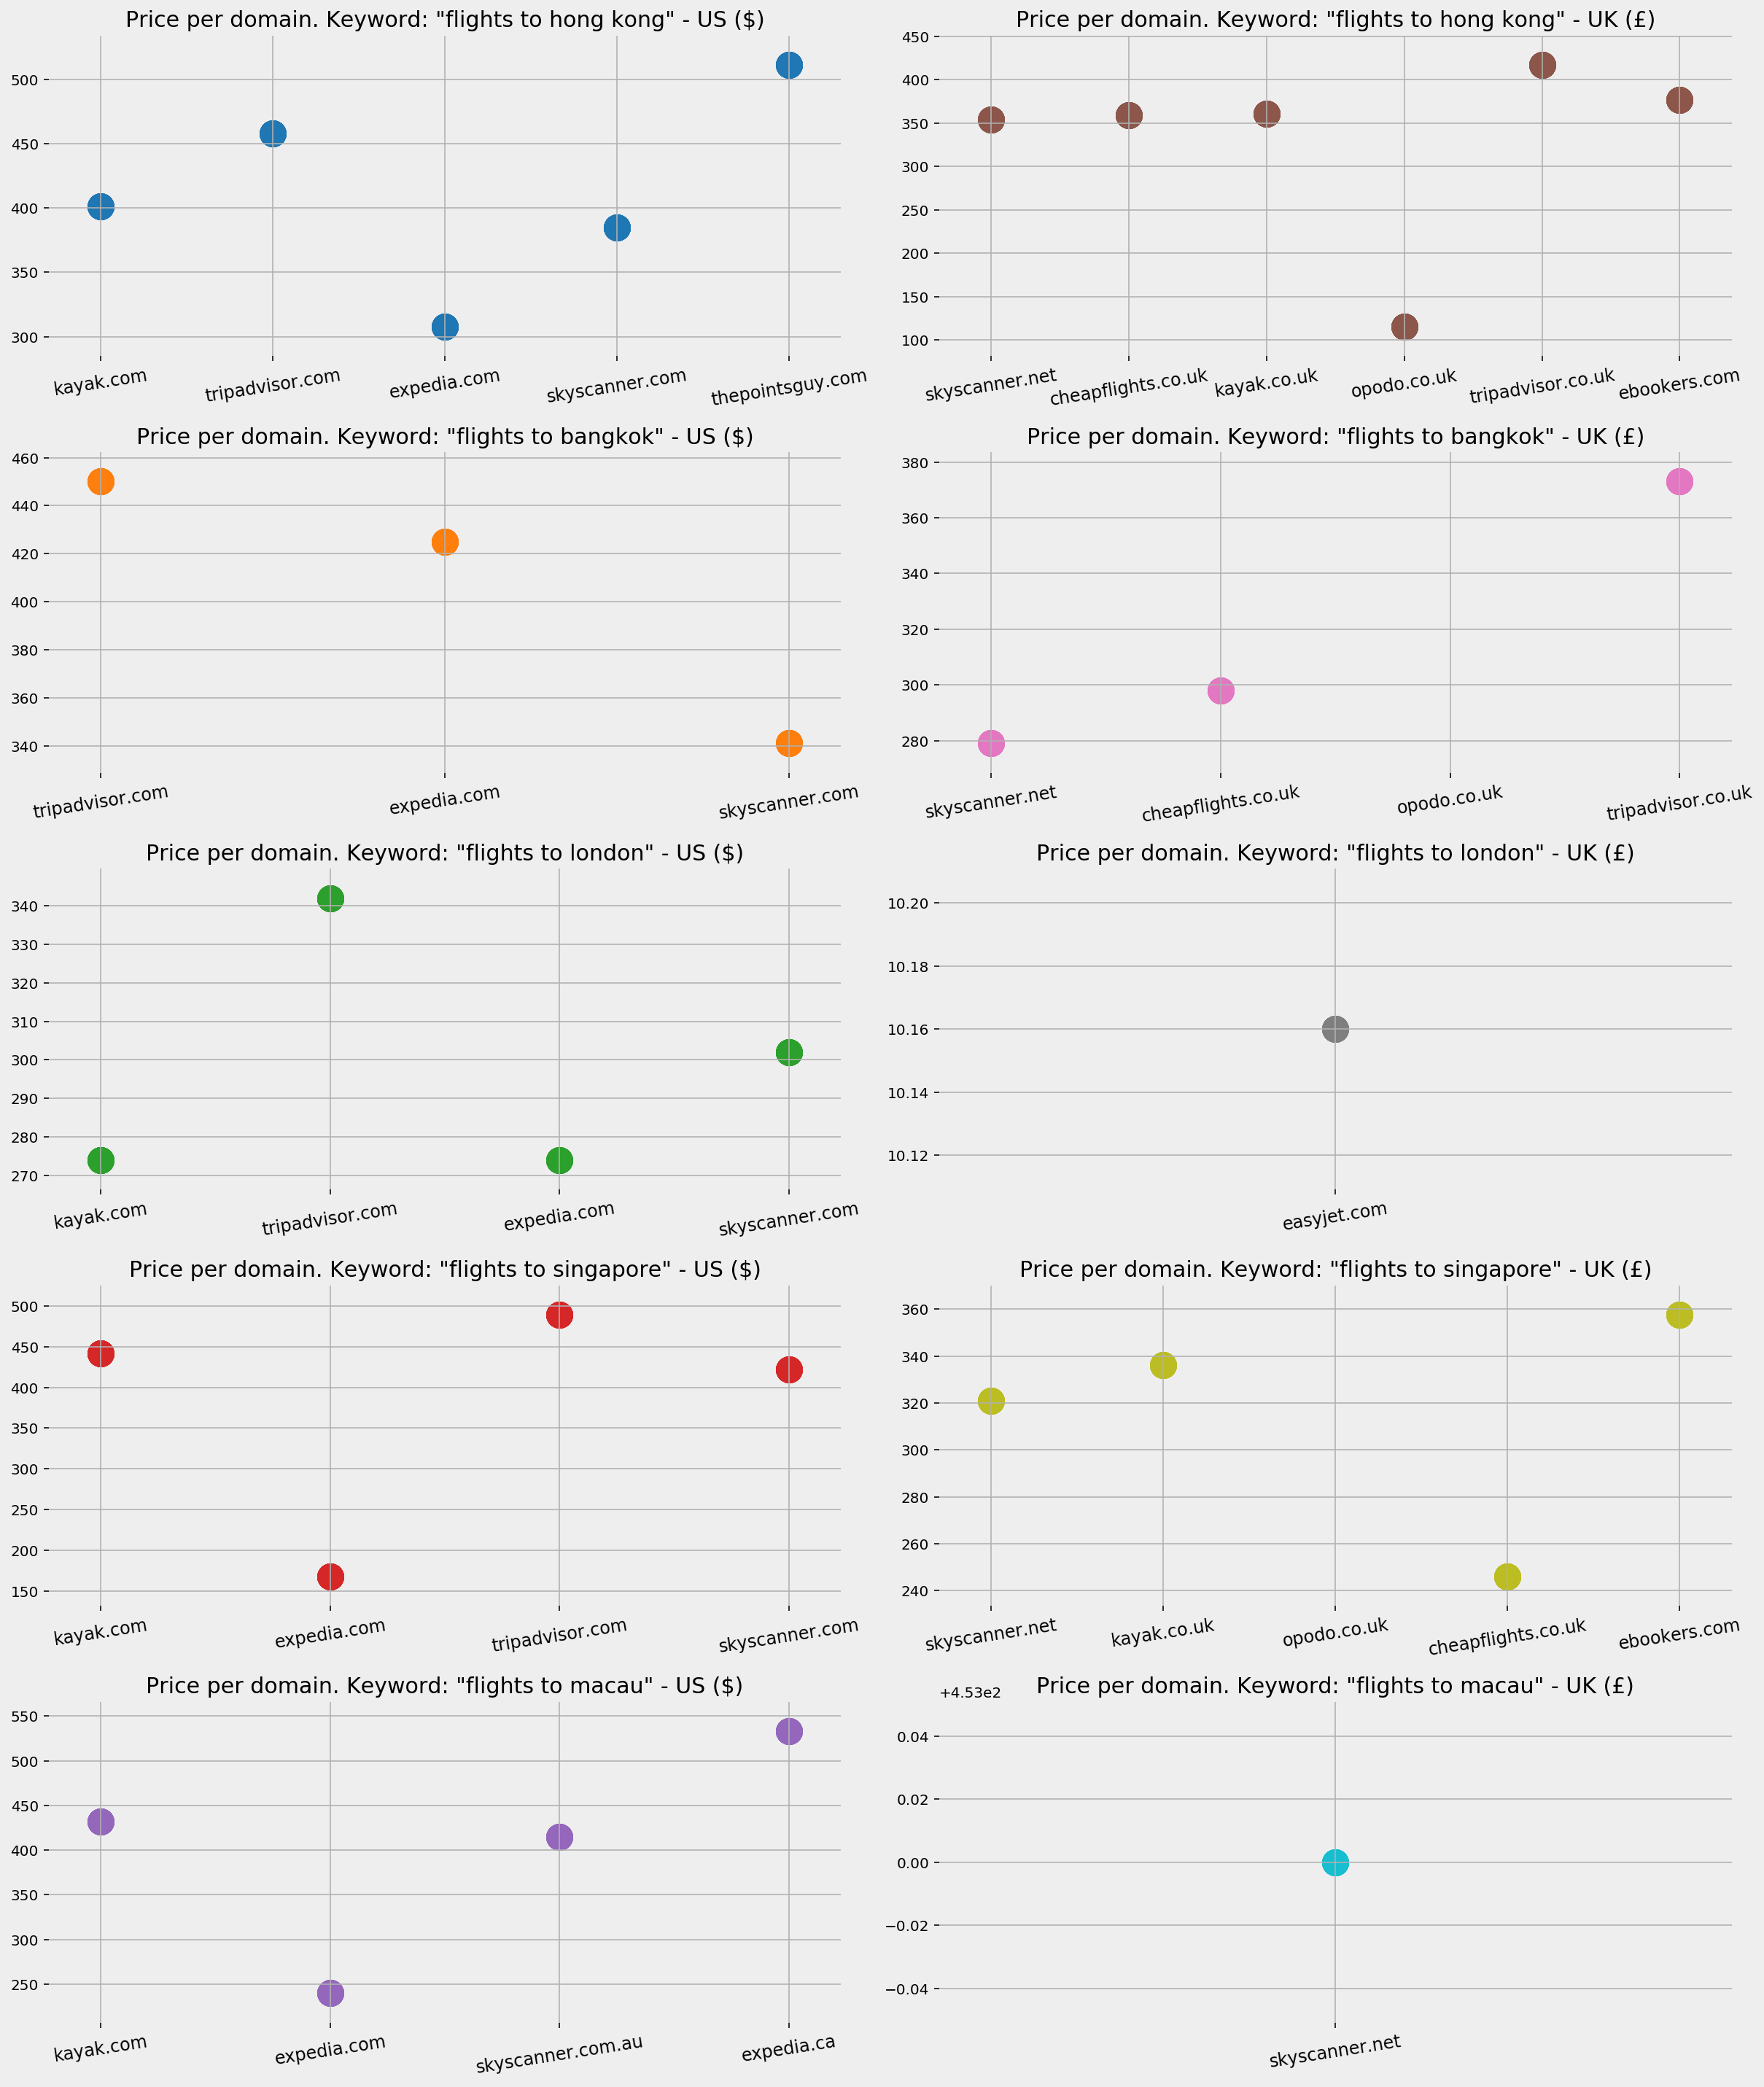

In [19]:
fig, ax = plt.subplots(5, 2, facecolor='#eeeeee')
fig.set_size_inches(17, 20)
countries = [' - US ($)', ' - UK (£)']
country_codes = ['us', 'uk']
currency = ['$', '£']
top10dfs = [top10_domains_us, top10_domains_uk]
for i in range(5):
    for j in range(2):
        ax[i, j].grid()        
        ax[i, j].set_frame_on(False)
        df = serp_flights[(serp_flights['gl'] == country_codes[j]) & 
                          (serp_flights['searchTerms'] == queries[i]) &
                          (serp_flights['currency'] == currency[j])]
        for country in top10dfs[j]:
            
            ax[i, j].scatter(df.sort_values('totalResults')['displayLink'].str.replace('www.', ''),
                             df.sort_values('totalResults')['price'],
                             color=tab10.colors[i+5*j], s=300)
            ax[i, j].set_title('Price per domain. Keyword: "' +  queries[i] + '"' + countries[j],
                               fontsize=15)
            ax[i, j].tick_params(labelsize=12, rotation=9, axis='x')
plt.tight_layout()
fig.savefig('Prices per domain' + '.png', 
            facecolor='#eeeeee', dpi=150, bbox_inches='tight')
            
plt.show()

In order to get a general overview of pricing for the top domains, we can also plot all instances where a price appears in a SERP, so we can see how prices compare overall by domain. 

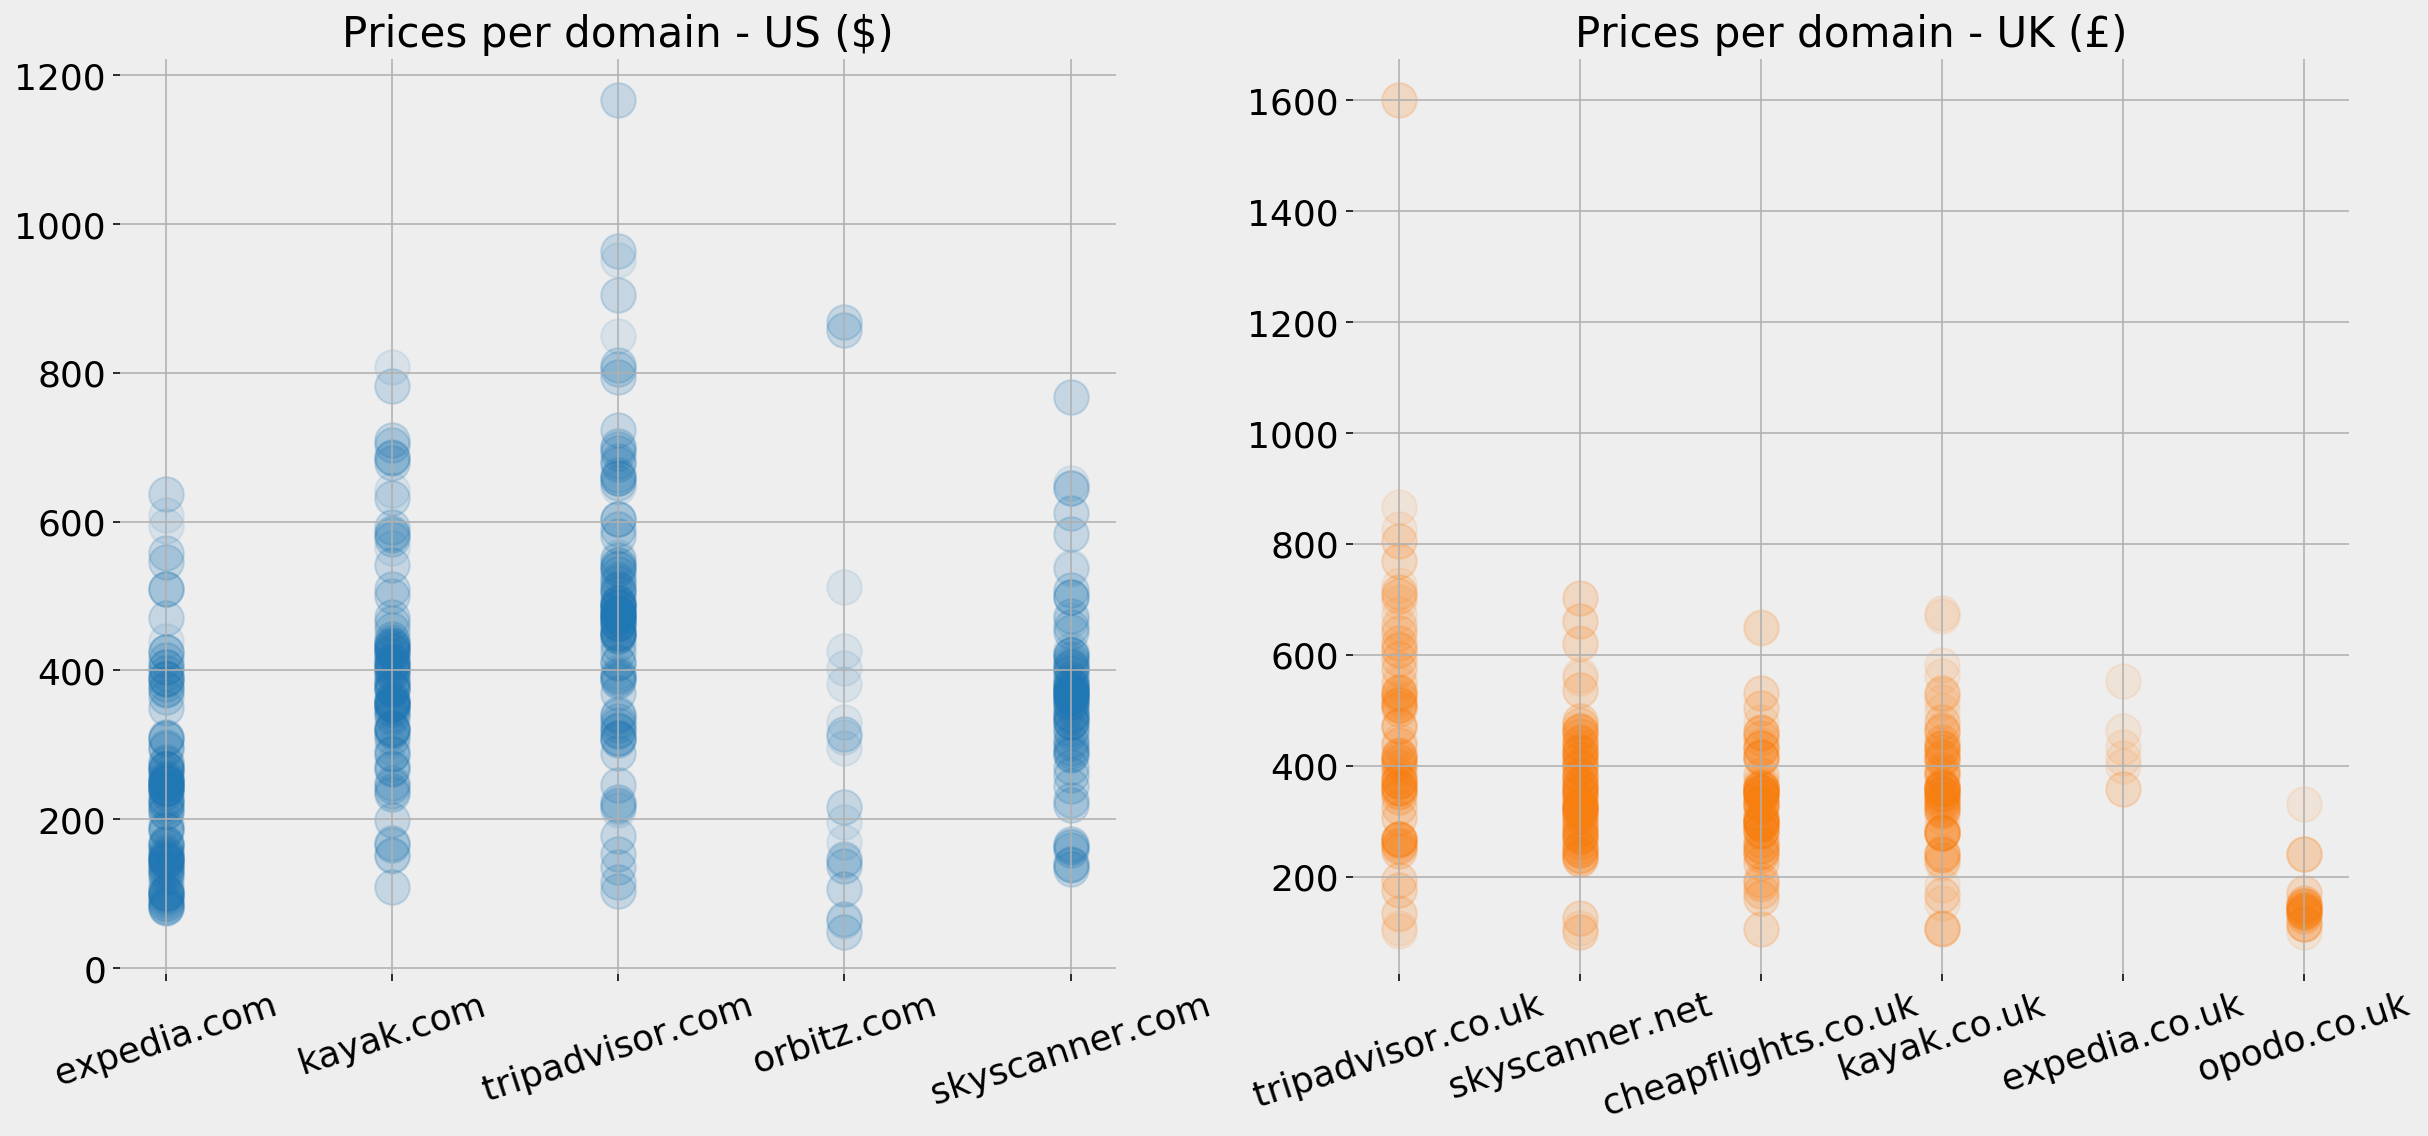

In [20]:
fig, ax = plt.subplots(1, 2, facecolor='#eeeeee')
fig.set_size_inches(17, 8)
countries = [' - US ($)', ' - UK (£)']
country_codes = ['us', 'uk']
currency = ['$', '£']
top10dfs = [top10_domains_us, top10_domains_uk]
for j in range(2):
    ax[j].grid()        
    ax[j].set_frame_on(False)
    df = serp_flights[(serp_flights['gl'] == country_codes[j]) & 
                      (serp_flights['currency'] == currency[j]) &
                      (serp_flights['displayLink'].isin(top10dfs[j]))]
    ax[j].scatter(df.sort_values('totalResults')['displayLink'].str.replace('www.', ''),
                     df.sort_values('totalResults')['price'] ,
                     color=tab10.colors[j], 
                  s=300, alpha=0.1)
    ax[j].set_title('Prices per domain'  + countries[j],
                       fontsize=21)
    ax[j].tick_params(labelsize=18, rotation=18, axis='x')
    ax[j].tick_params(labelsize=18, axis='y')
plt.tight_layout()
fig.savefig('Prices per country' + '.png', 
            facecolor='#eeeeee', dpi=150, bbox_inches='tight')
plt.show()

In the US, expedia.com clearly has lower prices on average, and a good portion of those is below 200 USD. tripadvisor.com seems to be the highest on average, but its prices have a higher range of fluctuation as well, compared to others.  
opodo.co.uk is clearly the cheapest for UK, with pretty much all its prices below 200 GBP. 
Keep in mind that the two charts have diferent scales, and they have different Y axes, and also that they show prices with different currencies. At the time of writing the GBP is around 1.30 USD.  
This does not necessarily mean that expedia.com has lower actual prices, as it could be "starting from" or with conditions, etc. But these are their advertised prices on SERPs.

### Peeking at snippets
As with titles we can do a similar analysis, but one site looked very interesting to me when it came to the text of their snippets, and that is kayak.com. 

Below is a sample of their snippets. Note that they mention airlines' names, prices, as well as source cities, even though the queries don't indicate wher the user is flying from.  
Note also that they are different for each query. For Hong Kong they say "from San Francisco" and "from New York" while for Dubai it's New York, Chicago, and Orlando.  
It seems that they have the snippets text dynamically generated based on the most frequent places people buy tickets from, and the airlines they use for those destinations.  
This could be an interesting insight on the market, or at least on Kayak's view of the market and how they position themselves.  
You might want to export the Kayak snippets, and generate a mapping between source and destination cities, as well as the airlines that they are most frequently associated with. 

In [21]:
with pd.option_context('display.max_colwidth', 200):
    print(*serp_flights[serp_flights['displayLink'] == 'www.kayak.com']['snippet'][:10].tolist(), sep='\n')

Find flights to Hong Kong on XiamenAir, Hong Kong Airlines, China Eastern and 
more. Fly round-trip from San Francisco from $402, from New York from $443, ...
Find flights to Bangkok on China Southern, China Eastern, Air China and more. 
Fly round-trip from San Francisco from $400, from New York from $439, from San
 ...
Find flights to London on Icelandair, Norwegian Air UK, WOW air and more. Fly 
round-trip from New York from $274, from Baltimore from $312, from Chicago ...
Find flights to Singapore on XiamenAir, Air China, China Eastern and more. Fly 
round-trip from San Francisco from $492, from New York from $460, from ...
Find flights to Macau on XiamenAir, China Eastern, Air China and more. Fly 
round-trip from San Francisco from $589, from New York from $499, from 
Honolulu ...
Find flights to Macau on XiamenAir, China Eastern, Air China and more. Fly 
round-trip from San Francisco from $589, from New York from $499, from 
Honolulu ...
Find flights to Dubai on Saudia, Norwegian,

So, that was a quick overview of how Google's CSE can be used to automate a large number of reports and a few ideas on what can be analyzed.  
Other things you might consider as well: 

- **Run the same report periodically**: Usually we are not only interested in a snapshot of where we stand. We are interested in knowing how our pages perform across time. So you might run the same report once a month for example, and have charts show how positions are changing in time.  
- **Assign weights to different destinations**: As mentioned above, we are assuming that all destinations are equal in value, and usually that is not the case. Try adding your own weights to each destination, maybe by taking into consideration the number of annual visitors mentioned in the table, or by utilizing your own conversion / sales / profitability data. 
- **Try other keywords and combinations**: Travel is one of the most complicated industries when it comes to generating and researching keywords. There are so many ways to express desire in traveling to a place (New York, New York City, ny, nyc, jfk, all mean the same thing when it comes to travel). Note that we didn't specify a "from" city, which makes a huge difference. Try "travel", "holidays" and / or pricing-related keywords. 
- **Try doing the same for YouTube SERPs**: [advertools](https://github.com/eliasdabbas/advertools) has a similar function for extraction similar data for videos. The YouTube data is much richer however, because it includes data about video views, ratings, number of comments, meta data about the channel, and much more.  
- **Build on this notebook**: Instead of re-inventing the wheel, you can get a copy of the same code and data, and run a different analysis, or produce different visualizations. I'd love to see other ideas or approaches. [add link to notebook]()

Good luck!